# Travelling salesman problem

Peter Voerman, 11749547

Nick van Santen, 11857846

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random

In [2]:
# Run cell to increase font sizes. Usefull when saving plots
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 100

## functions

### Read files

In [3]:
def read_file(filename):
    x_list = []
    y_list = []

    with open(filename, "r") as f:
        print(filename)
        for line in f.readlines()[6:-1]:
            split_line = line.split(' ')
            split_line = [x for x in split_line if x]
            x_list.append(float(split_line[-2]))
            y_list.append(float(split_line[-1]))

    return x_list, y_list

def read_solution(filename):
    node_list = []

    with open(filename, "r") as f:
        print(filename[-17:])
        if filename[-17:] == 'a280.opt.tour.txt':
            for line in f.readlines()[4:-1]:
                node_list.append(int(line))
        else:
            for line in f.readlines()[5:-2]:
                node_list.append(int(line))

    node_list.append(node_list[0])

    return node_list

### Distance

In [4]:
def create_distance_table(x_values, y_values):
    """
    Creates a dictionary with the distance city i and city j.

    Returns:
        distance_table: dictionary<int, dictionary<int, float>>
        int's refer to the cities and float refers to the distance between the cities
    """

    distance_table = {}
    if len(x_values) != len(y_values):
        raise Exception(f"Dimensions of x_values and y_values should be the same. {len(x_values)} vs {len(y_values)}")

    for i in range(len(x_values)):
        for j in range(len(y_values)):

            temp_i = i + 1
            temp_j = j + 1

            if temp_i not in distance_table:
                distance_table[temp_i] = {}

            x1, x2 = x_values[i], x_values[j]
            y1, y2 = y_values[i], y_values[j]

            distance_table[temp_i][temp_j] = calc_distance(x1, y1, x2, y2)

    return distance_table
    
def calc_distance(x1, y1, x2, y2):

    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

def calc_path_length(city_order, dist_table):
    
    path_length = 0
    for i in range(len(city_order) - 1):
        city1 = city_order[i]
        city2 = city_order[i + 1]

        path_length += dist_table[city1][city2]
    
    return path_length

### Plotting

In [5]:
def plot(x_points, y_points, route=None):
    x = np.zeros(len(route))
    y = np.zeros(len(route))
    for i in range(len(route)):
        x[i] = x_points[route[i]-1]
        y[i] = y_points[route[i]-1]
    plt.scatter(x_points, y_points)
    plt.plot(x, y)
    plt.show()

def plot_scores(scores):

    xs = np.arange(0, len(scores))

    plt.plot(xs, scores)

    plt.title("Distance evolution")
    plt.xlabel("Iteration")
    plt.ylabel("Distance")
    plt.show()

def plot_data(data, chain_plot=False, a_chain_length=0, b_chain_length=0):

    for a in data:
        
        fig, ax = plt.subplots()

        for b in data[a]:

            score_results = np.array(data[a][b])
            n_iterations = len(score_results[0])

            ys = np.mean(score_results, axis=0)
            ci = np.std(score_results, axis=0)
            xs = range(0, n_iterations)
            
            if not chain_plot:
                ax.plot(xs,ys, label=f"b={b}")
            else:
                ax.plot(xs, ys, label=f"Chain length={b}")
            ax.fill_between(xs, ys - ci, ys + ci, alpha=.1)

        ax.set_xlabel("Iterations")
        ax.set_ylabel("Scores")
        if not chain_plot:
            plt.title(f"a={a}")
        else:
            plt.title(f"a={a_chain_length}, b={b_chain_length} for different chain lengths")
        plt.legend()
        plt.show()

    if not chain_plot:
        for b in data[list(data.keys())[0]]:

            fig, ax = plt.subplots()

            for a in data:

                score_results = np.array(data[a][b])
                n_iterations = len(score_results[0])

                ys = np.mean(score_results, axis=0)
                ci = np.std(score_results, axis=0)
                xs = range(0, n_iterations)
                
                ax.plot(xs,ys, label=f"a={a}")
                ax.fill_between(xs, ys - ci, ys + ci, alpha=.1)
            
            ax.set_xlabel("Iterations")
            ax.set_ylabel("Scores")
            plt.title(f"b={b}")
            plt.legend()
            plt.show()

def plot_best_difference(data, optimal_score):

    fig, ax = plt.subplots()
    for a in data:

        means = []
        yerrors = []

        for b in data[a]:

            score_results = data[a][b]
            relative_errors = []
            for scores in score_results:
                min_score = min(scores)

                relative_errors.append((min_score - optimal_score) / optimal_score * 100)

            means.append(np.mean(relative_errors))
            yerrors.append(np.std(relative_errors))

        plt.errorbar(data[a].keys(), means, yerr=yerrors, label=f"a={a}", capsize=5)

    ax.set_title("Relative error compared to optimal solution")
    ax.set_xlabel("b")
    ax.set_ylabel("Relative error [%]")

    ax.set_yscale("log")
    ax.set_xscale("log")

    plt.legend()
    plt.show()

### Simulated annealing

In [6]:
def run(a, b, dist_table, iterations=10000, chain_length=1):
    temp_list = []
    n_cities = len(dist_table)
    current_order = [i for i in range(1, n_cities + 1)]
    current_order.append(1)
    current_score = calc_path_length(current_order, dist_table)
    
    orders = [current_order]
    scores = [current_score]
    last_value = np.inf

    for i in range(iterations):


        edge1 = random.randint(0, n_cities - 1)
        edge2 = random.randint(0, n_cities - 1)

        while abs(edge1 - edge2) < 2:
            edge1 = random.randint(0, n_cities - 1)
            edge2 = random.randint(0, n_cities - 1)
        
        temp_order = two_opt(current_order, edge1, edge2)
        temp_score = calc_path_length(temp_order, dist_table)

        if i % chain_length == 0:
            temperature = calc_temp(a, b, i/chain_length)
        temp_list.append(temperature)
        if temp_score < current_score or is_excepted(temp_score, last_value, temperature):
            current_score = temp_score
            current_order = temp_order

        scores.append(current_score)
        orders.append(current_order)

        last_value = current_score

    return scores, orders
       
def is_excepted(value, last_value, temperature):
    return random.random() < acceptance_change(value, last_value, temperature)     

def calc_temp(a, b, n):
    return a / np.log(n + b + 1)

def acceptance_change(value, last_value, temperature):
    return np.exp(-(value - last_value) / temperature)

def two_opt(order, city_1, city_2):
    if city_2 < city_1:
        city_1, city_2 = city_2, city_1
    new_order = np.zeros(len(order))
    new_order[:city_1] = order[:city_1]
    new_order[city_1:city_2] = list(reversed(order[city_1:city_2]))
    new_order[city_2:] = order[city_2:]
    new_order = [int(i) for i in new_order]
    if city_1 == 0:
        
        new_order[-1] = new_order[0]
    if city_2 == len(new_order):
        new_order[0] = new_order[-1]
    return new_order

### Data

In [7]:
def generate_data(a_values, b_values, nruns, dist_table, iterations=10000, chain_length=1):

    data = {}
    best_score = np.inf
    best_order = None
    
    for a in a_values:
        for b in b_values:
            print(f"\rCalculating a={a}, b={b}...", end="", flush=True)
            score_results = []

            for _ in range(nruns):

                scores, orders = run(a, b, dist_table, iterations=iterations, chain_length=chain_length)
                score_results.append(scores)

                min_score = min(scores)
                if min_score < best_score:
                    index = scores.index(min_score)
                    best_score = min_score
                    best_order = orders[index]

            if a not in data:
                data[a] = {}

            data[a][b] = score_results
    print()
    return data, best_score, best_order

def generate_chain_data(a, b, nruns, dist_table, chain_lengths, iterations=10000):
    data = {'1':{}}
    best_score = np.inf

    for length in chain_lengths:
        score_results = []
        print(length)

        for _ in range(nruns):
            scores, orders = run(a, b, dist_table, iterations=iterations, chain_length=length)

            score_results.append(scores)

            min_score = min(scores)
            if min_score < best_score:
                index = scores.index(min_score)
                best_score = min_score
                best_order = orders[index]

        data['1'][length] = score_results

    return data, best_score, best_order

def save_data(filename, data, best_score, best_order):
    with open(filename, 'wb') as f:
        pickle.dump([data, best_score, best_order], f)

def load_data(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

## Optimal solutions

TSP-Configurations/a280.tsp.txt
a280.opt.tour.txt
2586.7696475631606


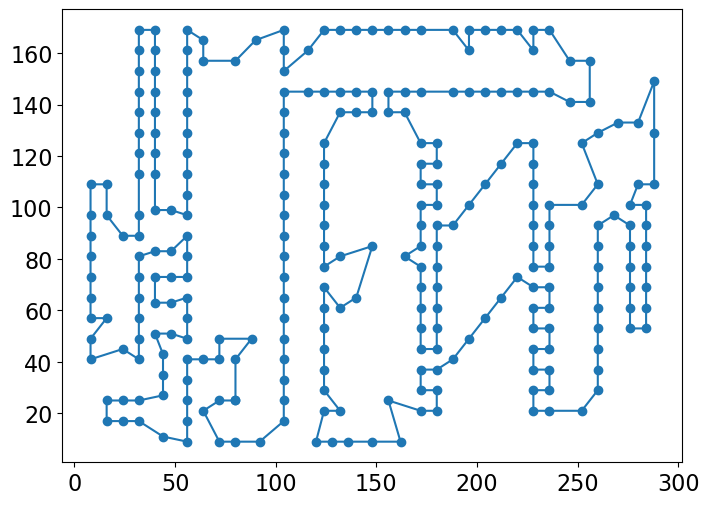

In [8]:
tsp_configuration = "a280"

x_values, y_values = read_file(f"TSP-Configurations/{tsp_configuration}.tsp.txt")
optimal_order = read_solution(f"TSP-Configurations/{tsp_configuration}.opt.tour.txt")

dist_table = create_distance_table(x_values, y_values)

optimal_score = calc_path_length(optimal_order, dist_table)
print(optimal_score)
plot(x_values, y_values, optimal_order)


## Calculating solutions

In [9]:
tsp_configuration = "a280"
cache_filename = f"data/{tsp_configuration}.pickle"
x_values, y_values = read_file(f"TSP-Configurations/{tsp_configuration}.tsp.txt")
optimal_order = read_solution(f"TSP-Configurations/{tsp_configuration}.opt.tour.txt")

dist_table = create_distance_table(x_values, y_values)

if os.path.isfile(cache_filename):
    print(f"Loading cached data from {cache_filename}")
    data, best_score, best_order = load_data(cache_filename)
else:
    print(f"Calculating cached data for {cache_filename}")

    a_values = [0.01, 0.1, 1, 10]
    b_values = [10000, 100000, 1000000]
    data, best_score, best_order = generate_data(a_values, b_values, 10, dist_table, chain_length=1, iterations=1000000)

    print(f"Saving data to {cache_filename}")
    save_data(cache_filename, data, best_score, best_order)

optimal_score = calc_path_length(optimal_order, dist_table)
print(optimal_score, best_score)

plot_best_difference(data, optimal_score)
plot_data(data)
plot(x_values, y_values, best_order)

TSP-Configurations/a280.tsp.txt
a280.opt.tour.txt
Calculating cached data for data/a280.pickle
Calculating a=0.01, b=100000...

KeyboardInterrupt: 

## Chain length analysis

In [11]:
a_values = 10
b_values = 10000
chain_lengths = [1, 5, 10, 50, 100]
data, best_score, best_order = generate_chain_data(a_values, b_values, 25, dist_table, chain_lengths, iterations=1000000)

optimal_score = calc_path_length(optimal_order, dist_table)
print(optimal_score, best_score)

plot_best_difference(data, optimal_score)
plot_data(data, chain_plot=True, a_chain_length=10, b_chain_length=10000)
plot(x_values, y_values, optimal_order)
save_data("data/a280_chain_lengths.pickle", data, best_score, best_order)


1


In [ ]:
tsp_configuration = "a280"
cache_filename = f"data/{tsp_configuration}_chains.pickle"
x_values, y_values = read_file(f"TSP-Configurations/{tsp_configuration}.tsp.txt")
optimal_order = read_solution(f"TSP-Configurations/{tsp_configuration}.opt.tour.txt")

dist_table = create_distance_table(x_values, y_values)

if os.path.isfile(cache_filename):
    print(f"Loading cached data from {cache_filename}")
    data, best_score, best_order = load_data(cache_filename)
else:
    print(f"Calculating cached data for {cache_filename}")

    a_values = [0.01, 0.1, 1, 10]
    b_values = [10000, 100000, 1000000]
    data, best_score, best_order = generate_data(a_values, b_values, 10, dist_table, chain_length=10, iterations=100000)

    print(f"Saving data to {cache_filename}")
    save_data(cache_filename, data, best_score, best_order)

optimal_score = calc_path_length(optimal_order, dist_table)
print(optimal_score, best_score)

plot_best_difference(data, optimal_score)
plot_data(data)
plot(x_values, y_values, best_order)

In [ ]:
a_values = 10
b_values = 10000
chain_lengths = [1, 5, 10, 50, 100]
data, best_score, best_order = generate_chain_data(a_values, b_values, 25, dist_table, chain_lengths, iterations=1000000)

optimal_score = calc_path_length(optimal_order, dist_table)
print(optimal_score, best_score)

plot_best_difference(data, optimal_score)
plot_data(data, chain_plot=True)
plot(x_values, y_values, optimal_order)